Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [1]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os


# для разделения выборок
from sklearn.model_selection import train_test_split

import tensorflow as tf

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

2025-06-14 12:06:29.207677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749891989.299419    1034 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749891989.323968    1034 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749891989.560547    1034 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749891989.560572    1034 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749891989.560573    1034 computation_placer.cc:177] computation placer alr

In [2]:

print(tf.config.list_physical_devices('GPU'))

[]


W0000 00:00:1749891994.670904    1034 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
# https://storage.yandexcloud.net/algorithmic-datasets/bus.zip
# gdown.download('https://storage.yandexcloud.net/algorithmic-datasets/bus.zip', None, quiet=True)

# # Распакуем архив в директорию 'content/bus'
# !unzip -q "bus.zip" -d /content/bus

# # Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = 'bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Входящий', 'Выходящий']

In [4]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [5]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg', '00010.jpg', '00011.jpg', '00012.jpg', '00013.jpg', '00014.jpg', '00015.jpg', '00016.jpg', '00017.jpg', '00018.jpg', '00019.jpg', '00020.jpg', '00021.jpg', '00022.jpg', '00023.jpg', '00024.jpg', '00025.jpg', '00026.jpg', '00027.jpg', '00028.jpg', '00029.jpg', '00030.jpg', '00031.jpg', '00032.jpg', '00033.jpg', '00034.jpg', '00035.jpg', '00036.jpg', '00037.jpg', '00038.jpg', '00039.jpg', '00040.jpg', '00041.jpg', '00042.jpg', '00043.jpg', '00044.jpg', '00045.jpg', '00046.jpg', '00047.jpg', '00048.jpg', '00049.jpg', '00050.jpg', '00051.jpg', '00052.jpg', '00053.jpg', '00054.jpg', '00055.jpg', '00056.jpg', '00057.jpg', '00058.jpg', '00059.jpg', '00060.jpg', '00061.jpg', '00062.jpg', '00063.jpg', '00064.jpg', '00065.jpg', '00066.jpg', '00067.jpg', '00068.jpg', '00069.jpg', '00070.jpg', '00071.jpg', '00072.jpg', '00073.jpg', '00074.jpg', '00075.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

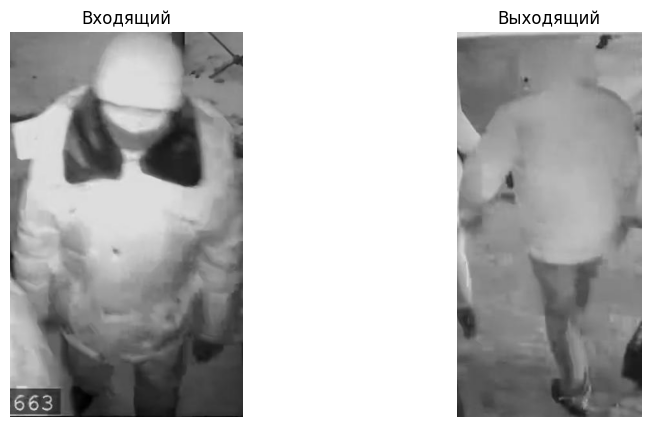

In [6]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [7]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))
print(data_labels[7000:7005])

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081
[1, 1, 1, 1, 1]


In [8]:
IMG_WIDTH = 128                      
IMG_HEIGHT = 64     

In [9]:
import numpy as np                        # Библиотека работы с массивами

data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 9081 фотографий следующей формы: (64, 128, 3)
Общий массив данных изображений следующей формы: (9081, 64, 128, 3)
Общий массив меток классов следующей формы: (9081,)


In [10]:
x_data[0]


array([[[141, 141, 141],
        [155, 155, 155],
        [172, 172, 172],
        ...,
        [ 58,  58,  58],
        [ 58,  58,  58],
        [ 58,  58,  58]],

       [[140, 140, 140],
        [157, 157, 157],
        [173, 173, 173],
        ...,
        [ 63,  63,  63],
        [ 63,  63,  63],
        [ 63,  63,  63]],

       [[131, 131, 131],
        [157, 157, 157],
        [171, 171, 171],
        ...,
        [ 69,  69,  69],
        [ 69,  69,  69],
        [ 69,  69,  69]],

       ...,

       [[ 86,  86,  86],
        [ 81,  81,  81],
        [ 77,  77,  77],
        ...,
        [124, 124, 124],
        [125, 125, 125],
        [125, 125, 125]],

       [[ 90,  90,  90],
        [ 86,  86,  86],
        [ 83,  83,  83],
        ...,
        [126, 126, 126],
        [126, 126, 126],
        [125, 125, 125]],

       [[ 82,  82,  82],
        [ 81,  81,  81],
        [ 81,  81,  81],
        ...,
        [129, 129, 129],
        [129, 129, 129],
        [127, 127, 127]]

In [11]:
x_data = x_data / 255.

In [12]:
# Создание модели последовательной архитектуры
model = Sequential()

# Первый сверточный блок
model.add(Conv2D(256, (3, 3), name='First_C', padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))  # (64,128,3) --> (64,128,256) меняется кол-во фильтров
model.add(BatchNormalization(name='First_B'))  # (64,128,256) --> (64,128,256) нет изменений

# Второй сверточный блок
model.add(Conv2D(256, (3, 3), name='Second_C', padding='same', activation='relu'))  # (64,128,256) --> (64,128,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Second_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (64,128,256) --> (21,42,256)

# Третий сверточный блок
model.add(Conv2D(256, (3, 3), name='Third_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(BatchNormalization(name='Third_B'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(Dropout(0.2, name='Third_D'))  # (21,42,256) --> (21,42,256) нет изменений

# Четвертый сверточный блок
model.add(Conv2D(256, (3, 3), name='Fourth_C', padding='same', activation='relu'))  # (21,42,256) --> (21,42,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Fourth_M'))  # сжимает размер в три раза, хотя padding='valid', потерь нет, т.к. делится нацело, глубина не изм. (21,42,256) --> (7,14,256)
model.add(Dropout(0.2, name='Fourth_D'))  # (7,14,256) --> (7,14,256) нет изменений

# Пятый сверточный блок
model.add(Conv2D(512, (3, 3), name='Fifth_D', padding='same', activation='relu'))  # (7,14,256) --> (7,14,512) меняется количество фильтров
model.add(BatchNormalization(name='Fifth_B'))  # (7,14,512) --> (7,14,512) нет изменений

# Шестой сверточный блок
model.add(Conv2D(1024, (3, 3), name='Sixth_C', padding='same', activation='relu'))  # (7,14,1024) --> (7,14,1024) меняется кол-во фильтров
model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (7,14,1024) --> (2,4,1024)
model.add(Dropout(0.2, name='Sixth_D'))  # (2,4,1024) --> (2,4,1024) нет изменений

# Блок классификации
model.add(Flatten(name='Class_1'))  # слой преобразования многомерных данных в одномерные (2,4,1024) --> (2*4*1024) --> (8192)
model.add(Dense(2048, activation='relu', name='Class_2'))  # полносвязный слой, меняется кол-во нейронов (8192) --> (2048)
model.add(Dense(4096, activation='relu', name='Class_3'))  # полносвязный слой, меняется кол-во нейронов (2048) --> (4096)
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_4'))  # выходной полносвязный слой, кол-во нейронов = количество классов (4096) --> (3)

/home/kvazistam/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1749891686.426875    9146 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-06-14 12:01:26.584756: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 10% of free system memory.
2025-06-14 12:01:26.590829: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 18874368 exceeds 1

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, shuffle=True)

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ First_C (Conv2D)                │ (None, 64, 128, 256)   │         7,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ First_B (BatchNormalization)    │ (None, 64, 128, 256)   │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Second_C (Conv2D)               │ (None, 64, 128, 256)   │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Second_M (MaxPooling2D)         │ (None, 21, 42, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Third_C (Conv2D)                │ (None, 21, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Third_B (BatchNormalization)    │ (None, 21, 42, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Third_D (Dropout)               │ (None, 21, 42, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Fourth_C (Conv2D)               │ (None, 21, 42, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Fourth_M (MaxPooling2D)         │ (None, 7, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Fourth_D (Dropout)              │ (None, 7, 14, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Fifth_D (Conv2D)                │ (None, 7, 14, 512)     │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Fifth_B (BatchNormalization)    │ (None, 7, 14, 512)     │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Sixth_C (Conv2D)                │ (None, 7, 14, 1024)    │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Sixth_M (MaxPooling2D)          │ (None, 2, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Sixth_D (Dropout)               │ (None, 2, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Class_1 (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Class_2 (Dense)                 │ (None, 2048)           │    16,779,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Class_3 (Dense)                 │ (None, 4096)           │     8,392,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Class_4 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,861,442 (125.36 MB)

 Trainable params: 32,859,394 (125.35 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [15]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
print("GPUs available:", tf.config.list_physical_devices('GPU'))

GPUs available: []


: 

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(x_train,  # ----------------- x_train, примеры набора данных
                           y_train,  # ----------------- y_train, метки примеров набора данных
                           validation_split=0.2,  # --- 0.2 - доля данных для валидационной (проверочной) выборки, 1-0.2=0.8 останется в обучающей
                           shuffle=True,  # ----------- перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется
                           batch_size=100,  # ---------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                           epochs=50,  # -------------- epochs - количество эпох обучения
                           verbose=1)  # -------------- 0 - не визуализировать ход обучения, 1 - визуализировать

Epoch 1/50
